# Libraries

In [1]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn.linear_model import LinearRegression

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [2]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for index, filename in enumerate(files):

    if not index % 1000:
        print(index, " | ", end=" ")  # Counter
    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)  # Read file

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Set Title

        url = data[0]["url"]  # Set URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)
        # if not any(
        #     x in url
        #     for x in {
        #         "wsj.com",
        #         "usatoday.com",
        #         "nytimes.com",
        #         "latimes.com",
        #         "nypost.com",
        #         "washingtonpost.com",
        #         "chicagotribune.com",
        #         "chron.com",
        #         "nydailynews.com",
        #         "theguardian.com",
        #     }
        # ):
        #     continue  # Whitelist

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Set max
        if len(entities) <= 1:
            continue  # Set min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if tag.startswith("US "):
                    tag = tag[3:]  # Remove prefix
                if tag.endswith(" Corp"):
                    tag = tag[:-5]  # Remive postfix
                if tag.endswith(" Inc"):
                    tag = tag[:-4]  # Remive postfix
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

    except:
        continue  # In case of error

    articles.append(
        [year, title, url, list(set(subjects)), list(set(orgs)), list(set(people))]
    )

articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
)  # Dataset

articles = articles.drop_duplicates(subset=['url']) # Remove articles with the same URL

articles.head(1)


0  |  1000  |  2000  |  3000  |  4000  |  5000  |  6000  |  7000  |  8000  |  9000  |  10000  |  11000  |  12000  |  13000  |  14000  |  15000  |  16000  |  17000  |  18000  |  19000  |  20000  |  21000  |  22000  |  23000  |  24000  |  25000  |  26000  |  

,year,title,url,subjects,orgs,people
0,2013,Two people rescued from house fire,http://www.bbc.co.uk/news/uk-wales-mid-wales-2...,"[fires and firemen, rescues, fires and firefig...",[],[]


## Entities

In [96]:
entities = np.empty((0, 11), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}

for index, row in articles.iterrows():

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "subject",
                            1,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                            None,
                            None,
                            None,
                            None,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)  # URL
            entities[index, 5][0].append(title)  # Title
            entities[index, 6][0] += co  # Co-occurrences

    for entity in row["orgs"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "org",
                            1,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                            None,
                            None,
                            None,
                            None,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)  # URL
            entities[index, 5][0].append(title)  # Title
            entities[index, 6][0] += co  # Co-occurrences

    for entity in row["people"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "person",
                            1,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                            None,
                            None,
                            None,
                            None,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][3][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 3][0][year] += 1  # Year
            entities[index, 4][0].append(url)  # URL
            entities[index, 5][0].append(title)  # Title
            entities[index, 6][0] += co  # Co-occurrences


entities = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "years",
        "urls",
        "titles",
        "cooccurrences",
        "slope",
        "color",
        'x',
        'y',
    ],
)  # Dataset

entities.sort_values(by=["frequency"], ascending=False).head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
3,energy and power,subject,1163,"{2011: 8, 2012: 12, 2013: 42, 2014: 33, 2015: ...",[http://www.staradvertiser.com/business/kauai-...,"[Kauai utility cuts its greenhouse emissions, ...","[air pollution, weather, light, electric light...",None,None,None,None


# Analysis

## Linear regression

In [97]:
for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope

entities.sort_values(by=["slope"], ascending=False).head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
3,energy and power,subject,1163,"{2011: 8, 2012: 12, 2013: 42, 2014: 33, 2015: ...",[http://www.staradvertiser.com/business/kauai-...,"[Kauai utility cuts its greenhouse emissions, ...","[air pollution, weather, light, electric light...",19.145455,None,None,None


## Colors

In [98]:
cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    entities.at[i, 'color'] = cmap(norm(row['slope']))

entities.sort_values(by=["slope"], ascending=False).head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
3,energy and power,subject,1163,"{2011: 8, 2012: 12, 2013: 42, 2014: 33, 2015: ...",[http://www.staradvertiser.com/business/kauai-...,"[Kauai utility cuts its greenhouse emissions, ...","[air pollution, weather, light, electric light...",19.145455,"(0.705673158, 0.01555616, 0.150232812, 1.0)",None,None


## Frequency

In [99]:
entities_filtered = entities.loc[entities['frequency'] > 10]

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities_filtered["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

entities_filtered.head(1)


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
0,fires and firemen,subject,14,"{2011: 0, 2012: 0, 2013: 2, 2014: 0, 2015: 1, ...",[http://www.bbc.co.uk/news/uk-wales-mid-wales-...,"[Two people rescued from house fire, Aid Deal ...","[rescues, fires and firefighters, fires and fi...",0.254545,"(0.9595176584705882, 0.7669728545098039, 0.674...",None,None


## UMAP

In [100]:
# reducer = umap.UMAP(random_state=42, n_components=2, n_neighbors=2, min_dist=.1, metric='cosine')
reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=2, min_dist=0.1, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

entities_filtered['x'] = pd.Series(embedding[:, 0])
entities_filtered['y'] = pd.Series(embedding[:, 1])

entities_filtered.head(1)


 * creating mesh with size 34 34
 * filling mesh


/var/folders/lr/mmry4yv506b3rqk3bgm2s_j80000gn/T/ipykernel_65334/1301533207.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entities_filtered['x'] = pd.Series(embedding[:, 0])
/var/folders/lr/mmry4yv506b3rqk3bgm2s_j80000gn/T/ipykernel_65334/1301533207.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entities_filtered['y'] = pd.Series(embedding[:, 1])


,name,type,frequency,years,urls,titles,cooccurrences,slope,color,x,y
0,fires and firemen,subject,14,"{2011: 0, 2012: 0, 2013: 2, 2014: 0, 2015: 1, ...",[http://www.bbc.co.uk/news/uk-wales-mid-wales-...,"[Two people rescued from house fire, Aid Deal ...","[rescues, fires and firefighters, fires and fi...",0.254545,"(0.9595176584705882, 0.7669728545098039, 0.674...",5.595306,0.929964


## Clustering

In [75]:
# cluster_selection_epsilon = radius
# min_samples = number of close elements to create a set

clusterer = hdbscan.HDBSCAN(min_samples=3, cluster_selection_epsilon=0.2)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=3, cluster_selection_epsilon=.5)
# clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon=0.5, cluster_selection_method='leaf')
# min_samples is to consier all the elements that owtherwide will be classified as noise
# cluster_selection_epsilon extends clusters


clusterer.fit(embedding)
clusters = clusterer.labels_

# Grouping by cluster

values = set(clusters)
if -1 in values:
    values.remove(-1)

clusters = [
    [index for index, cluster in enumerate(clusters) if cluster == value]
    for value in values
]

len(clusters)


9

# Plotting

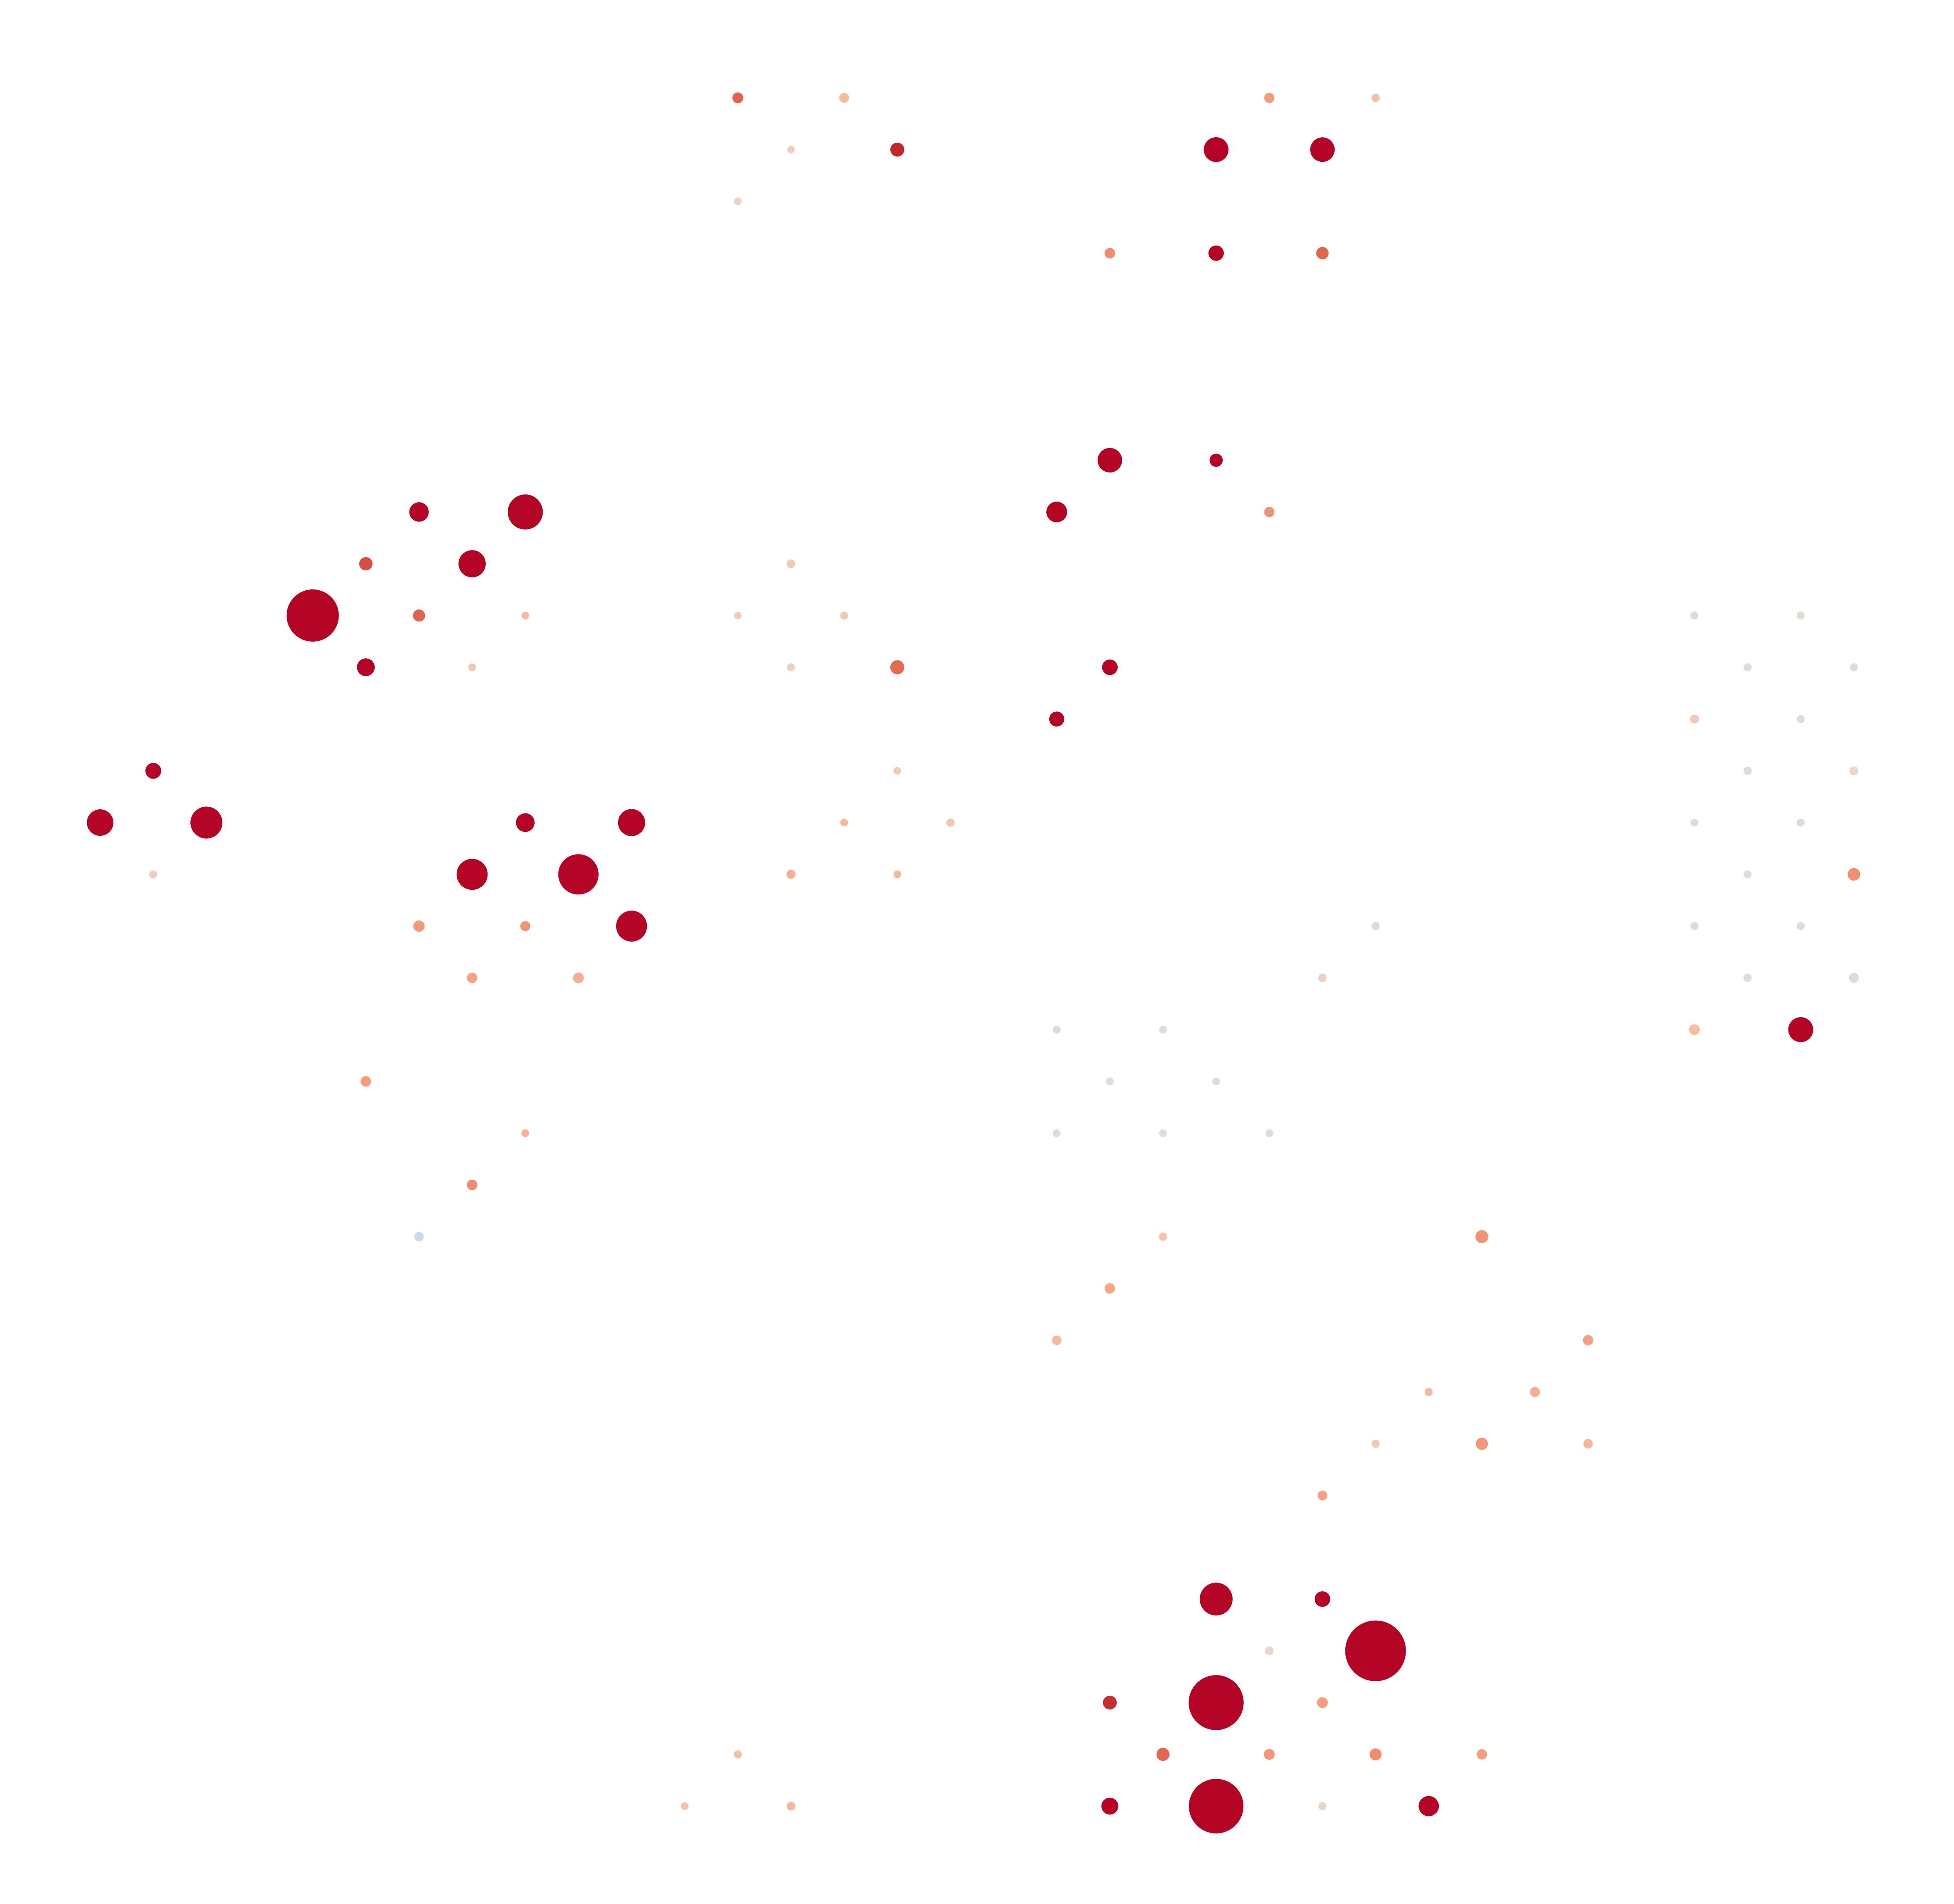

In [76]:
# Frame

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot



plt.scatter(x, y, s=entities_filtered['frequency'].to_list(), c=entities_filtered['color'].to_list())
# plt.scatter(x, y, s=40, c=colors)


# Labels

# for i, txt in enumerate(orgs):
#     # text = plt.annotate(orgs[i], xy=(x[i], y[i] - math.sqrt(occurences[i]/math.pi)/40), ha='center', va='bottom')
#     text = plt.annotate(orgs[i], xy=(x[i], y[i]), ha="center", va="bottom")
#     text.set_fontsize(3)

# plt.savefig("download.png")


# Saving files

In [90]:
entities_filtered.to_csv("src/data/entities.csv", index=False)
